In [1]:
!pip install -q transformers datasets

In [2]:
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:


train_data, test_data = load_dataset('cifar10', split=['train', 'test'])

splits = train_data.train_test_split(test_size=0.1)
train_data = splits['train']
val_data = splits['test']

print(train_data)
print(test_data)
print(val_data)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})


In [4]:
labelnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  _, axs = plt.subplots(3, 3, figsize=(3 * 3, 3 * 3))
  axs = axs.flatten()
  for img, title, ax in zip(imgs, titles, axs):
    ax.imshow(img)
    ax.set_title(title)
  plt.show()

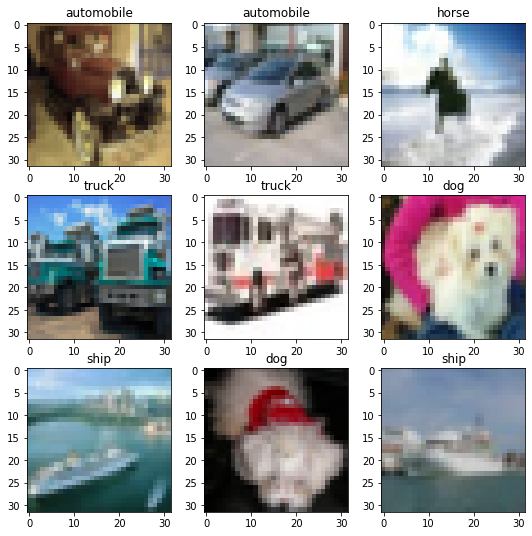

In [6]:
images, labels = train_data[0:9]['img'], train_data[0:9]['label']
titles = [labelnames[label] for label in labels]
show_img_grid(images, titles)

In [7]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments
from datasets import load_metric

# ViT Feature Extractor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path, size=32)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [8]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 32
}

In [9]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([_train_transforms(x.convert("RGB")) for x in batch['img']], return_tensors='pt')

    inputs['labels'] = batch['label']
    return inputs

def val_transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([_val_transforms(x.convert("RGB")) for x in batch['img']], return_tensors='pt')

    inputs['labels'] = batch['label']
    return inputs


train_data.set_transform(train_transform)
val_data.set_transform(val_transform)
test_data.set_transform(val_transform)

In [10]:
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [11]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=10,
    # num_channels=1,
    # patch_size=16
    image_size=32,
    ignore_mismatched_sizes=True
)

# Training Args
training_args = TrainingArguments(
  output_dir="./vit-cifar-v1",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='logs',
    remove_unused_columns=False,
  fp16=True,
  )

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClass

In [12]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [13]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45000
  Num Epochs = 6
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 13500
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.691300,1.662315,0.397200
2,1.551800,1.541108,0.453400
3,1.501000,1.470787,0.477200
4,1.433700,1.423608,0.492000
5,1.399800,1.391562,0.507600
6,1.385800,1.378166,0.510600


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to ./vit-cifar-v1/checkpoint-2250
Configuration saved in ./vit-cifar-v1/checkpoint-2250/config.json
Model weights saved in ./vit-cifar-v1/checkpoint-2250/pytorch_model.bin
Feature extractor saved in ./vit-cifar-v1/checkpoint-2250/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to ./vit-cifar-v1/checkpoint-4500
Configuration saved in ./vit-cifar-v1/checkpoint-4500/config.json
Model weights saved in ./vit-cifar-v1/checkpoint-4500/pytorch_model.bin
Feature extractor saved in ./vit-cifar-v1/checkpoint-4500/preprocessor_config.json
/opt/conda/lib/python3.7/site

***** train metrics *****
  epoch                    =         6.0
  total_flos               = 397016721GF
  train_loss               =      1.5231
  train_runtime            =  0:47:01.40
  train_samples_per_second =      95.697
  train_steps_per_second   =       4.785


In [14]:
outputs = trainer.predict(test_data)

***** Running Prediction *****
  Num examples = 10000
  Batch size = 8
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [15]:
outputs

PredictionOutput(predictions=array([[ 0.3735 , -0.5903 , -1.071  , ..., -0.0875 , -0.704  ,  0.3157 ],
       [ 0.237  ,  3.947  , -1.015  , ..., -1.1875 ,  1.633  ,  1.013  ],
       [ 0.2272 ,  3.453  , -1.199  , ..., -1.002  ,  2.512  ,  0.739  ],
       ...,
       [-0.8853 , -1.792  ,  2.615  , ...,  0.4272 , -1.183  , -1.7    ],
       [-0.708  ,  0.1982 ,  0.08716, ...,  0.6855 , -1.694  , -0.754  ],
       [-0.627  , -1.352  ,  0.1937 , ...,  3.762  , -1.127  , -0.5005 ]],
      dtype=float16), label_ids=array([3, 8, 8, ..., 5, 1, 7]), metrics={'test_loss': 1.3616576194763184, 'test_accuracy': 0.5237, 'test_runtime': 69.6493, 'test_samples_per_second': 143.577, 'test_steps_per_second': 17.947})

              precision    recall  f1-score   support

    airplane       0.57      0.64      0.60      1000
  automobile       0.64      0.63      0.63      1000
        bird       0.52      0.28      0.36      1000
         cat       0.44      0.30      0.36      1000
        deer       0.45      0.40      0.42      1000
         dog       0.47      0.38      0.42      1000
        frog       0.47      0.70      0.56      1000
       horse       0.51      0.61      0.56      1000
        ship       0.62      0.66      0.63      1000
       truck       0.53      0.64      0.58      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000



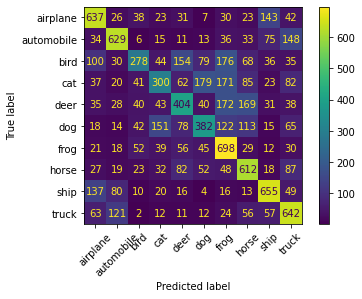

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelnames)
disp.plot(xticks_rotation=45)

print(classification_report(y_true, y_pred, target_names=labelnames))